In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path

In [44]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    ##r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt" # Hela dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [45]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# flag outliers
bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

# # interpolate the gaps
# df_all = df_all.set_index('datetime')              # make time the index  
# df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
# df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density

In [46]:
print(df_all.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source'],
      dtype='object')


In [47]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

In [48]:
print(df_all[['Temp_in_SBE38',
              'Salinity_SBE45',
              'pressure']].describe())
print(df_all[['Temp_in_SBE38',
              'Salinity_SBE45',
              'pressure']].min())

       Temp_in_SBE38  Salinity_SBE45     pressure
count    1006.000000     1007.000000  1007.000000
mean       10.781919       27.115382   198.431789
std         0.381554        2.397987     4.249278
min         9.374091       20.841084   181.850334
25%        10.583493       24.952120   195.432025
50%        10.766748       26.759772   197.165197
75%        11.019055       29.583948   201.214438
max        11.639323       31.262650   222.921207
Temp_in_SBE38       9.374091
Salinity_SBE45     20.841084
pressure          181.850334
dtype: float64


In [49]:
print(df_all.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0'],
      dtype='object')


In [104]:
print(df_all['CT'].mean())

10.920346241570332


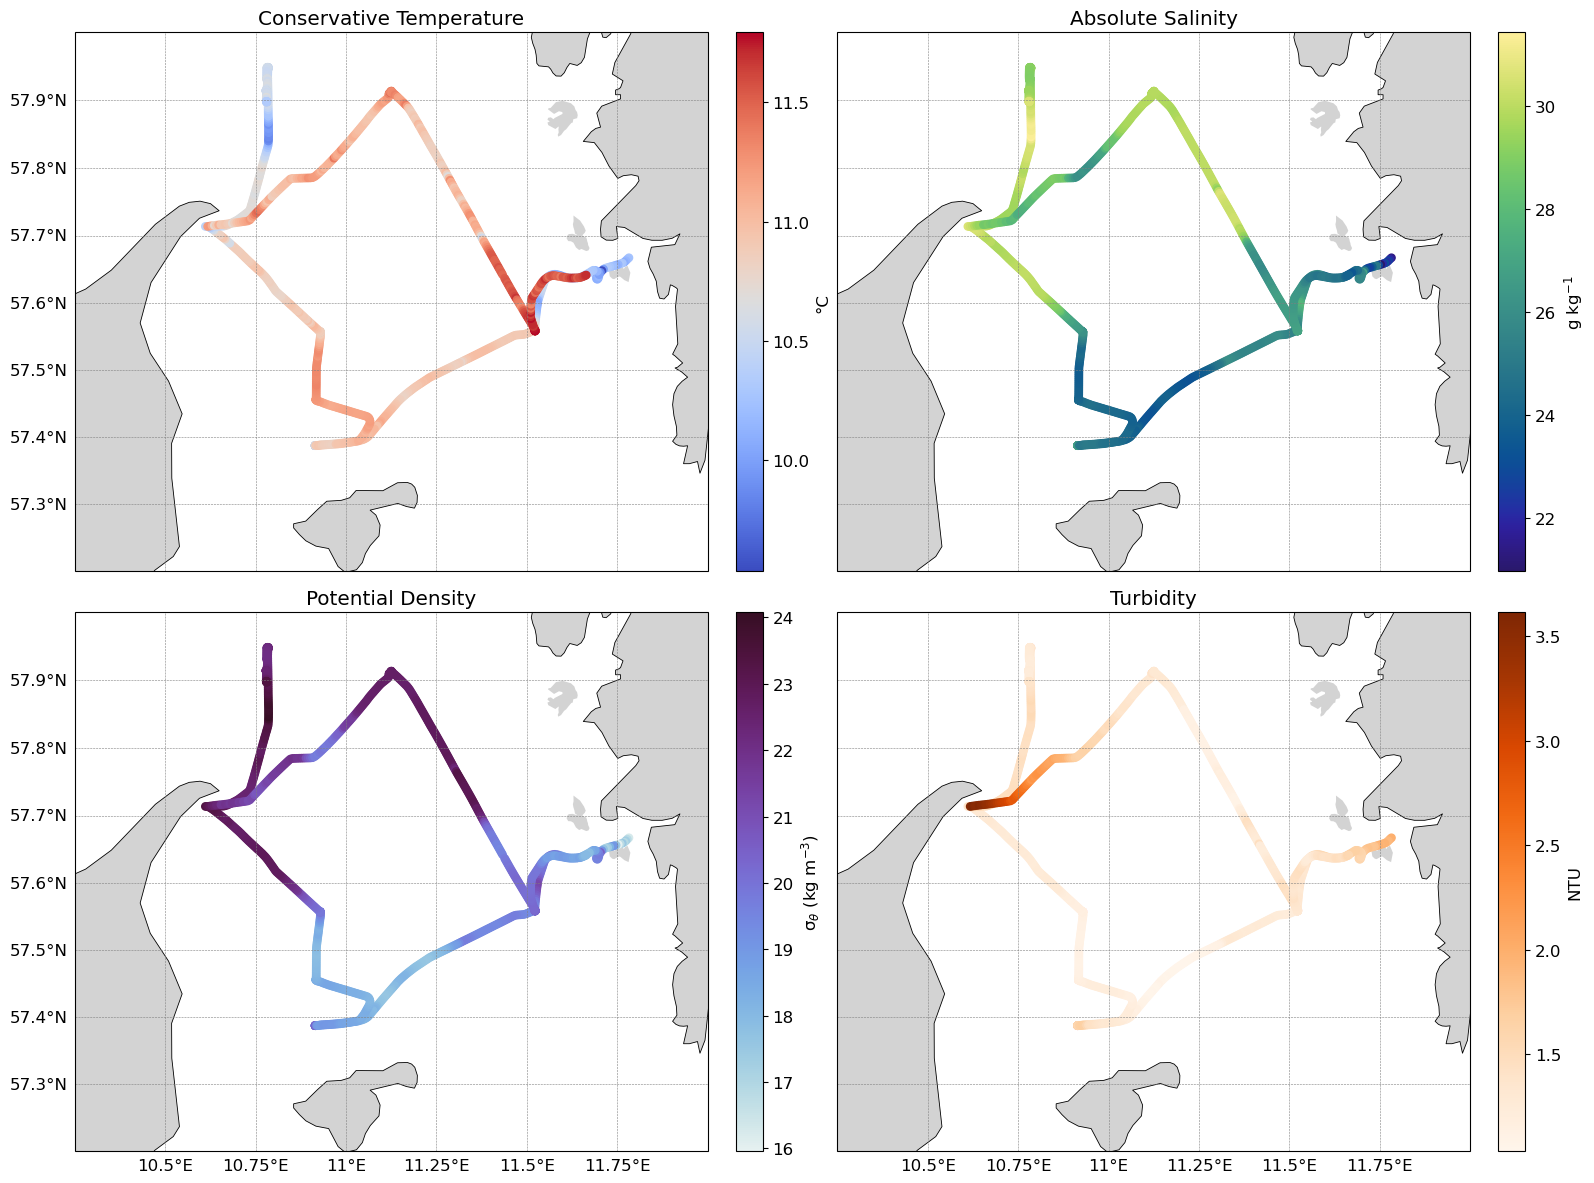

In [51]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})      # pick any base size you like


# Choose what variables to visualize

lon, lat = df_all["Longitude"], df_all["Latitude"]

variables = ["CT", "SA", "sigma0", "Turbidity"]
titles    = ["Conservative Temperature", "Absolute Salinity", "Potential Density", "Turbidity"]
cmaps     = ["coolwarm", "cmo.haline", "cmo.dense", "Oranges"]
cbar_titles  = ["°C", "g kg$^{-1}$", "σ$_\\theta$ (kg m$^{-3}$)", "NTU"]  

extent = [10.25, 12, 57.2, 58]

# 2 × 2 map panel
norms = {v: mpl.colors.Normalize(df_all[v].min(), df_all[v].max()) for v in variables}

fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                         subplot_kw={"projection": ccrs.Mercator()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.4)

    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
    gl.top_labels = gl.right_labels = False
    if i % 2:  gl.left_labels   = False
    if i < 2:  gl.bottom_labels = False

    sc = ax.scatter(lon, lat,
                    c=df_all[variables[i]],
                    cmap=cmaps[i],
                    norm=norms[variables[i]],
                    s=28,
                    transform=ccrs.PlateCarree())

    cbar = plt.colorbar(sc, ax=ax, orientation="vertical",
                        fraction=0.046, pad=0.04)
    cbar.set_label(cbar_titles[i]) 
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

Here is a way to control/check each variable:

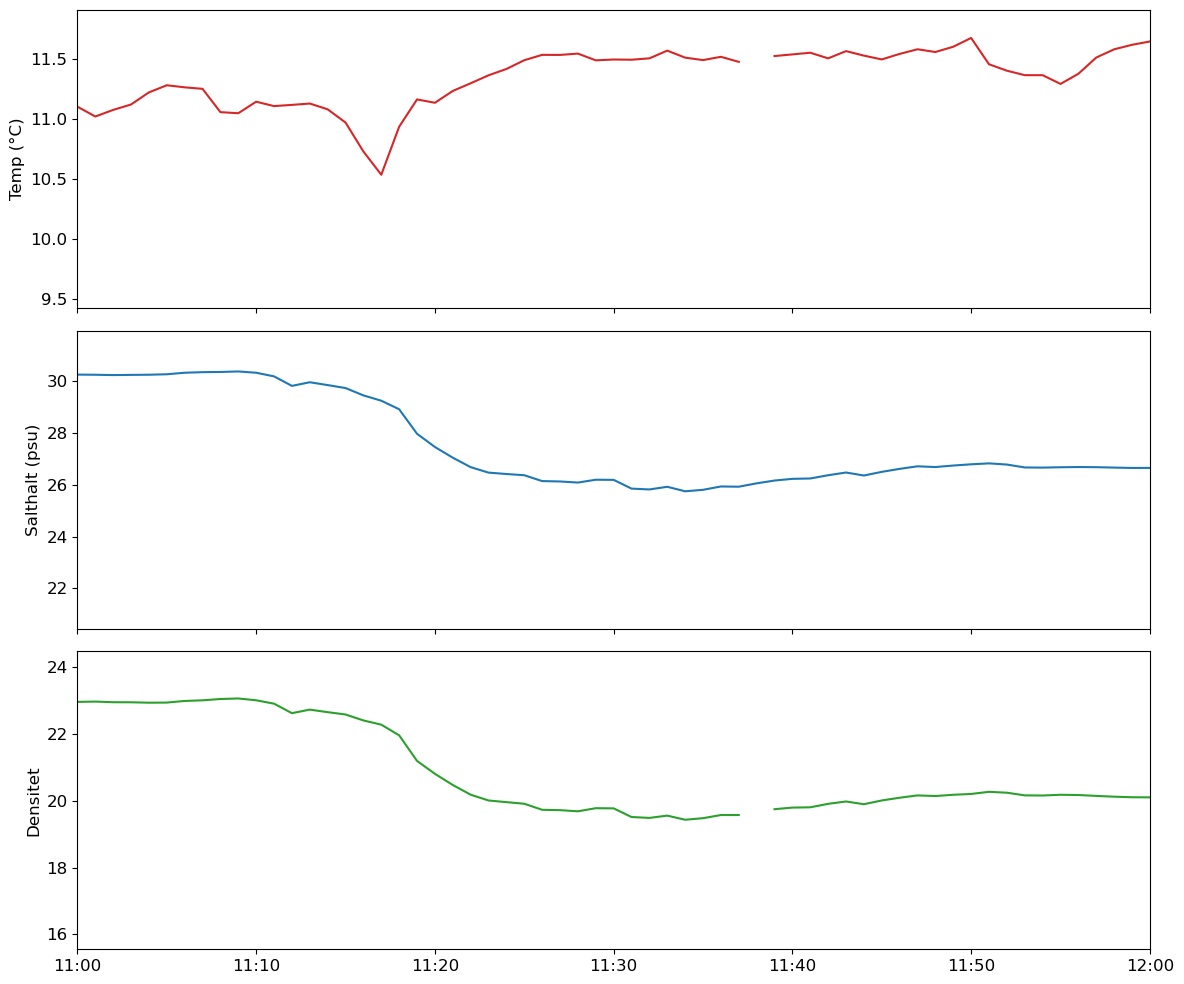

In [52]:
import pandas as pd
import matplotlib.dates as mdates

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axs[0].plot(df_all['datetime'], df_all['CT'],      color='tab:red')
axs[1].plot(df_all['datetime'], df_all['SA'],      color='tab:blue')
axs[2].plot(df_all['datetime'], df_all['sigma0'],  color='tab:green')

axs[0].set_ylabel('Temp (°C)')
axs[1].set_ylabel('Salthalt (psu)')
axs[2].set_ylabel('Densitet')

# ――― zoom window (05-08 11:00 → 12:00) ―――
start = pd.Timestamp('2025-05-08 11:00')
end   = pd.Timestamp('2025-05-08 12:00')
for ax in axs:
    ax.set_xlim(start, end)
#    ax.set_ylim(10.3,11.8)

# optional: nicer hour labels
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()


Now I want to compute the Bouyancy gradient

In [53]:
# Option 1 of computing bouy grad

from pyproj import Geod
from scipy.interpolate import interp1d

g    = 9.81          # gravity (m s-2)
#rho0 = 1025.0        # reference density (kg m-3)
rho0 = np.nanmean(df_all['sigma0']+1000)

# distance along track (m)
geod = Geod(ellps="WGS84")
lon  = df_all["Longitude"].to_numpy()
lat  = df_all["Latitude"].to_numpy()
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))      # 0, 730 m, 1490 m, …

# buoyancy b = g (1 – ρ/ρ₀)  with ρ = σθ + 1000
rho = df_all["sigma0"].to_numpy() + 1000.0
b   = g * (1 - rho / rho0)

# regular 500 m distance grid
d_reg = np.arange(0, dist[-1], 1000.0)

# interpolate buoyancy onto this grid
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# constant-spacing gradient (Δx = 500 m)
dbdx_reg = np.gradient(b_reg, 500.0)          # s-2 on the regular grid

# map the regular-grid gradient back onto the original rows
df_all["buoy_grad"] = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)


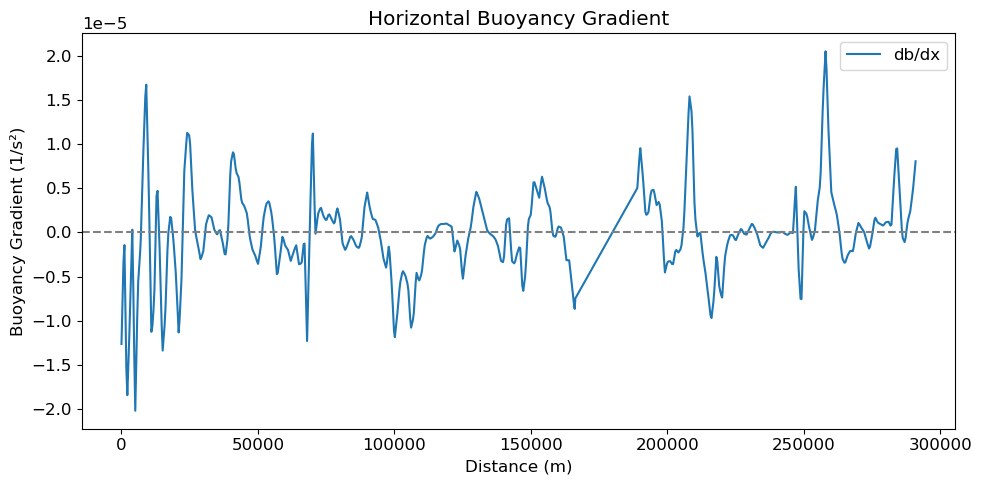

In [54]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(dist, df_all['buoy_grad'], label=f'db/dx')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance (m)')
plt.ylabel('Buoyancy Gradient (1/s²)')
plt.title(f'Horizontal Buoyancy Gradient')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# # Option 2 of computing the bouy grad
# from pyproj import Geod
# from scipy.interpolate import interp1d

# g =  9.81
# rho0 = 1025.0

# # get distance along track (m)
# geod = Geod(ellps="WGS84")
# lon, lat = df_all["Longitude"].to_numpy(), df_all["Latitude"].to_numpy()
# _, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
# dist = np.concatenate(([0.0], np.cumsum(step)))

# # buoyancy 
# rho = df_all["sigma0"].to_numpy() + 1000.0
# b   = g * (1 - rho / rho0)

# # regular 500 m grid
# d_reg = np.arange(0, dist[-1], 500.0)
# b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)

# # finite-difference gradient then rolling mean 
# dbdx_reg = np.gradient(b_reg, 500.0)                 # raw gradient
# dbdx_smooth = (pd.Series(dbdx_reg)
#                .rolling(5, center=True)              # 5-point window (≈2 km)
#                .mean()
#                .to_numpy())

# #  map back to original rows
# df_all["buoy_grad"] = np.interp(dist, d_reg, dbdx_smooth,
#                                 left=np.nan, right=np.nan)


In [56]:
# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(dist, df_all['buoy_grad'], label=f'db/dx')
# plt.axhline(0, color='gray', linestyle='--')
# plt.xlabel('Distance (m)')
# plt.ylabel('Buoyancy Gradient (1/s²)')
# plt.title(f'Horizontal Buoyancy Gradient')
# plt.legend()
# plt.tight_layout()
# plt.show()

But might be better to do for each dataset separatly since its now interpolating in between the datasets, where there are no measurments

In [57]:
df_all

,Date,Time,Latitude,Longitude,Course,Speed,Temp_SBE45,Cond_SBE45,Salinity_SBE45,SoundVel_SBE45,...,flow_main,flow_SBE45,Phycocyanin,CDOM,datetime,source,SA,CT,sigma0,buoy_grad
0,2025.05.06,07:37:00,57.667360,11.782509,227.331050,11.000000,10.153903,2.439251,21.301802,1473.792397,...,8.967182,3.310180,1.031333,-0.015625,2025-05-06 07:37:00,224_2025-05-06_07.35.09__to_Skagen_741601,21.436299,10.254032,16.303825,-0.000013
1,2025.05.06,07:38:00,57.665152,11.778037,226.105023,11.000000,10.168917,2.505584,21.929166,1474.605690,...,8.943592,3.302311,1.012083,-0.017500,2025-05-06 07:38:00,224_2025-05-06_07.35.09__to_Skagen_741601,22.065062,10.224740,16.793212,-0.000008
2,2025.05.06,07:39:00,57.662873,11.773772,223.215103,11.000000,10.182814,2.569033,22.530538,1475.383397,...,8.978257,3.304303,0.981750,-0.018750,2025-05-06 07:39:00,224_2025-05-06_07.35.09__to_Skagen_741601,22.667775,10.155634,17.268184,-0.000003
3,2025.05.06,07:40:00,57.660707,11.769391,234.350000,11.000000,10.144962,2.512420,22.009384,1474.613534,...,8.977371,3.320903,1.022583,-0.014375,2025-05-06 07:40:00,224_2025-05-06_07.35.09__to_Skagen_741601,22.145459,10.093534,16.873470,-0.000001
4,2025.05.06,07:41:00,57.659370,11.764079,249.522831,11.000000,10.074745,2.594584,22.844819,1475.362052,...,8.952452,3.320804,1.133417,-0.017708,2025-05-06 07:41:00,224_2025-05-06_07.35.09__to_Skagen_741601,22.982756,10.282755,17.493411,-0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2025.05.08,13:12:00,57.638496,11.650834,70.002604,8.820312,11.485521,2.866192,24.526834,1482.518397,...,8.364591,3.082295,0.752500,-0.017083,2025-05-08 13:12:00,2025-05-08_07.24.29_Skagen_to__741601,24.668522,11.585651,18.594547,0.000007
1003,2025.05.08,13:13:00,57.639379,11.654892,66.361979,7.278646,11.550995,2.825029,24.096572,1482.238310,...,8.363262,3.074161,0.824471,-0.014391,2025-05-08 13:13:00,2025-05-08_07.24.29_Skagen_to__741601,24.237300,11.621150,18.257451,0.000008
1004,2025.05.08,13:14:00,57.640176,11.658264,64.705729,6.130208,11.528721,2.805852,23.930964,1481.961241,...,8.347536,3.073530,0.845250,-0.017083,2025-05-08 13:14:00,2025-05-08_07.24.29_Skagen_to__741601,24.071323,11.631943,18.128182,NaN
1005,2025.05.08,13:15:00,57.640952,11.661359,64.786458,6.000000,11.557531,2.788179,23.746614,1481.844138,...,8.343881,3.066425,0.845250,-0.016875,2025-05-08 13:15:00,2025-05-08_07.24.29_Skagen_to__741601,23.886562,11.672815,17.979700,NaN


Open the weather data to compute the Ekman bouyancy flux

In [58]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [59]:
print(df_all.columns)
print(df_wind.columns)
print(df_pos.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0',
       'buoy_grad'],
      dtype='object')
Index(['ts', 'airtemp', 'humidity', 'airpressure', 'windspeed', 'winddir'], dtype='object')
Index(['ts', 'latitude', 'longitude', 'gndspeed', 'gndcourse', 'gps_quality',
       'nbused', 'hdop'],
      dtype='object')


In [60]:
# # first few rows
print(df_wind.head())        # or df_wind.sample(5) for random rows
print(df_pos.head())

# column names
print(df_wind.columns)
print(df_pos.columns)

# # quick summary of types / non-null counts
# df_wind.info()
# df_pos.info()

                    ts  airtemp  humidity  airpressure  windspeed  winddir
0  2025-05-06 07:00:00      8.8        42       1014.2        3.4       12
1  2025-05-06 07:01:00      8.8        42       1014.2        3.3       13
2  2025-05-06 07:02:00      8.8        43       1014.3        3.1      332
3  2025-05-06 07:03:00      8.8        42       1014.2        2.5        7
4  2025-05-06 07:04:00      8.9        42       1014.2        3.8      356
                    ts   latitude  longitude  gndspeed  gndcourse  \
0  2025-05-06 07:00:00  57.686355  11.893357       0.0     329.60   
1  2025-05-06 07:01:00  57.686355  11.893356       0.0      96.92   
2  2025-05-06 07:02:00  57.686355  11.893358       0.0     156.77   
3  2025-05-06 07:03:00  57.686355  11.893356       0.0      95.12   
4  2025-05-06 07:04:00  57.686363  11.893342       0.0     247.44   

   gps_quality  nbused  hdop  
0            5       9   1.3  
1            5       9   1.3  
2            5       9   1.3  
3          

In [61]:
print(df_wind['windspeed'].describe())   # should be in the 0–25 m s⁻¹ range

count    3258.000000
mean        2.708379
std         3.040649
min         0.000000
25%         0.600000
50%         1.400000
75%         3.600000
max        15.800000
Name: windspeed, dtype: float64


In [62]:
# df_wind['ts'] = pd.to_datetime(df_wind['ts'])
# df_pos ['ts'] = pd.to_datetime(df_pos ['ts'])


In [63]:
# df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
# df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

# df = pd.merge_asof(
#     df_pos.sort_values('ts'),
#     df_wind.sort_values('ts'),
#     on='ts',
#     direction='nearest',
#     tolerance=pd.Timedelta('10s')  # try 5–10 seconds
# ).dropna(subset=['windspeed'])  # ensure you keep only aligned rows


In [64]:
# df_wind['ts'] = df_wind['ts'].dt.round('1min')
# df_pos ['ts'] = df_pos ['ts'].dt.round('1min')

# df = pd.merge_asof(df_pos.sort_values('ts'), df_wind.sort_values('ts'), on='ts',
#                    direction='nearest', tolerance=pd.Timedelta('1min')).dropna(subset=['windspeed'])        # keep rows with wind data


In [65]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [66]:
df = df.rename(columns={'ts': 'Time'})
df = df.rename(columns={'longitude': 'Longitude'})
df = df.rename(columns={'latitude': 'Latitude'})

<Axes: >

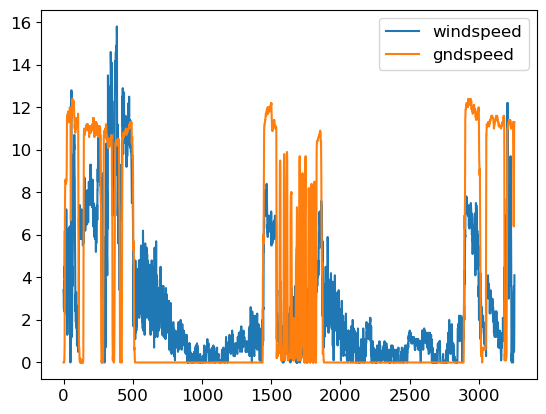

In [67]:
# quick sanity: compare wind to ship speed
df[['windspeed', 'gndspeed']].plot()


In [68]:
# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df['airtemp'   ].to_numpy(float)         # °C
P   = df['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df['humidity'  ].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df['windspeed'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df['winddir'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df['tau']   = tau
df['tau_x'] = tau_x
df['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df[['Time', 'Latitude', 'Longitude', 'tau', 'tau_x', 'tau_y']].head())

                 Time   Latitude  Longitude       tau     tau_x     tau_y
0 2025-05-06 07:00:00  57.686355  11.893357  0.021691 -0.004510 -0.021217
1 2025-05-06 07:01:00  57.686355  11.893356  0.020434 -0.004597 -0.019910
2 2025-05-06 07:02:00  57.686355  11.893358  0.018033  0.008466 -0.015922
3 2025-05-06 07:03:00  57.686355  11.893356  0.011727 -0.001429 -0.011640
4 2025-05-06 07:04:00  57.686363  11.893342  0.027085  0.001889 -0.027019


In [69]:
df_may_8 = df[df['Time'].astype(str).str.startswith('2025-05-08')]
df_may_7 = df[df['Time'].astype(str).str.startswith('2025-05-07')]
df_may_6 = df[df['Time'].astype(str).str.startswith('2025-05-06')]

In [77]:
df_all_may_8 = df_all[df_all['Time'].astype(str).str.startswith('2025-05-08')]
df_all_may_6 = df_all[df_all['Date'].astype(str).str.startswith('2025-05-06')]

In [79]:
print(df_all_may_6)

Empty DataFrame
Columns: [Date, Time, Latitude, Longitude, Course, Speed, Temp_SBE45, Cond_SBE45, Salinity_SBE45, SoundVel_SBE45, Temp_in_SBE38, Oxygen, Saturation, Temperature_Optode, pH, Chlorophyll, Turbidity, pressure, flow_main, flow_SBE45, Phycocyanin, CDOM, datetime, source, SA, CT, sigma0, buoy_grad]
Index: []

[0 rows x 28 columns]


In [80]:
print(df)

                    Time   Latitude  Longitude  gndspeed  gndcourse  \
0    2025-05-06 07:00:00  57.686355  11.893357       0.0     329.60   
1    2025-05-06 07:01:00  57.686355  11.893356       0.0      96.92   
2    2025-05-06 07:02:00  57.686355  11.893358       0.0     156.77   
3    2025-05-06 07:03:00  57.686355  11.893356       0.0      95.12   
4    2025-05-06 07:04:00  57.686363  11.893342       0.0     247.44   
...                  ...        ...        ...       ...        ...   
3253 2025-05-08 13:13:00  57.642033  11.665780       7.2      65.03   
3254 2025-05-08 13:14:00  57.642999  11.669698       9.5      66.01   
3255 2025-05-08 13:15:00  57.644032  11.674796      11.1      71.54   
3256 2025-05-08 13:16:00  57.644881  11.680356      11.2      74.19   
3257 2025-05-08 13:17:00  57.645732  11.686053      11.3      74.31   

      gps_quality  nbused  hdop  airtemp  humidity  airpressure  windspeed  \
0               5       9   1.3      8.8        42       1014.2      

In [78]:
print(df_may_6.head)
print(df_all_may_6.head)

<bound method NDFrame.head of                     Time   Latitude  Longitude  gndspeed  gndcourse  \
0    2025-05-06 07:00:00  57.686355  11.893357       0.0     329.60   
1    2025-05-06 07:01:00  57.686355  11.893356       0.0      96.92   
2    2025-05-06 07:02:00  57.686355  11.893358       0.0     156.77   
3    2025-05-06 07:03:00  57.686355  11.893356       0.0      95.12   
4    2025-05-06 07:04:00  57.686363  11.893342       0.0     247.44   
...                  ...        ...        ...       ...        ...   
1015 2025-05-06 23:55:00  57.720676  10.600306       0.0     213.28   
1016 2025-05-06 23:56:00  57.720676  10.600306       0.0     293.71   
1017 2025-05-06 23:57:00  57.720676  10.600306       0.0       3.06   
1018 2025-05-06 23:58:00  57.720676  10.600306       0.0      95.19   
1019 2025-05-06 23:59:00  57.720676  10.600306       0.0     157.69   

      gps_quality  nbused  hdop  airtemp  humidity  airpressure  windspeed  \
0               5       9   1.3      8.

In [81]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df['datetime'] = pd.to_datetime(df['Time'])


In [83]:
print(df_all['datetime'])
print(df['datetime'])

0      2025-05-06 07:37:00
1      2025-05-06 07:38:00
2      2025-05-06 07:39:00
3      2025-05-06 07:40:00
4      2025-05-06 07:41:00
               ...        
1002   2025-05-08 13:12:00
1003   2025-05-08 13:13:00
1004   2025-05-08 13:14:00
1005   2025-05-08 13:15:00
1006   2025-05-08 13:16:00
Name: datetime, Length: 1007, dtype: datetime64[ns]
0      2025-05-06 07:00:00
1      2025-05-06 07:01:00
2      2025-05-06 07:02:00
3      2025-05-06 07:03:00
4      2025-05-06 07:04:00
               ...        
3253   2025-05-08 13:13:00
3254   2025-05-08 13:14:00
3255   2025-05-08 13:15:00
3256   2025-05-08 13:16:00
3257   2025-05-08 13:17:00
Name: datetime, Length: 3258, dtype: datetime64[ns]


In [ ]:
df_all = df_all.sort_values('datetime')
df = df.sort_values('datetime')

df_merged = pd.merge_asof(df_all, df, on='datetime', direction='nearest', tolerance=pd.Timedelta('10s'))


In [86]:
print(df_merged.columns)

Index(['Date', 'Time_x', 'Latitude_x', 'Longitude_x', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0',
       'buoy_grad', 'Time_y', 'Latitude_y', 'Longitude_y', 'gndspeed',
       'gndcourse', 'gps_quality', 'nbused', 'hdop', 'airtemp', 'humidity',
       'airpressure', 'windspeed', 'winddir', 'tau', 'tau_x', 'tau_y'],
      dtype='object')


In [87]:
import numpy as np
from pyproj import Geod

geod = Geod(ellps='WGS84')

# Distance between the two GPS positions
lons1 = df_merged['Longitude_x'].to_numpy()
lats1 = df_merged['Latitude_x'].to_numpy()
lons2 = df_merged['Longitude_y'].to_numpy()
lats2 = df_merged['Latitude_y'].to_numpy()

_, _, distance = geod.inv(lons1, lats1, lons2, lats2)
df_merged['gps_offset_m'] = distance

print("GPS offset (meters):")
print(df_merged['gps_offset_m'].describe())


GPS offset (meters):
count    1007.000000
mean      921.338830
std       470.068889
min         3.228995
25%       762.823979
50%      1175.041215
75%      1214.296979
max      1379.426807
Name: gps_offset_m, dtype: float64


In [93]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))

df_all[df_all['datetime'].dt.strftime('%H:%M') == '11:37']


,Date,Time,Latitude,Longitude,Course,Speed,Temp_SBE45,Cond_SBE45,Salinity_SBE45,SoundVel_SBE45,...,flow_main,flow_SBE45,Phycocyanin,CDOM,datetime,source,SA,CT,sigma0,buoy_grad
240,2025.05.06,11:37:00,57.387834,10.914456,227.836364,0.0,10.722374,2.891779,25.286667,1480.683638,...,8.620756,3.234052,0.640500,-0.015833,2025-05-06 11:37:00,224_2025-05-06_07.35.09__to_Skagen_741601,25.430049,10.453478,19.357051,9.717527e-08
907,2025.05.08,11:37:00,57.642292,11.433066,150.039900,11.0,11.474928,2.997951,25.779821,1483.977293,...,8.482540,3.090993,0.625333,-0.017500,2025-05-08 11:37:00,2025-05-08_07.24.29_Skagen_to__741601,25.924303,11.474182,19.578000,-2.981235e-06


In [89]:
# Same time
df[df['datetime'].dt.strftime('%H:%M') == '07:37']

# +2 hours (e.g., if one is in UTC and the other in CEST)
df[df['datetime'].dt.strftime('%H:%M') == '09:37']


,Time,Latitude,Longitude,gndspeed,gndcourse,gps_quality,nbused,hdop,airtemp,humidity,airpressure,windspeed,winddir,tau,tau_x,tau_y,datetime
157,2025-05-06 09:37:00,57.550044,11.458355,10.9,244.23,5,8,1.0,9.0,45,1015.5,6.2,62,0.072157,-0.063711,-0.033876,2025-05-06 09:37:00
1597,2025-05-07 09:37:00,57.914603,10.780417,4.3,212.37,5,8,1.0,9.8,55,1022.1,0.5,3,0.000471,-0.000025,-0.000470,2025-05-07 09:37:00
3037,2025-05-08 09:37:00,57.911801,11.123278,0.6,35.01,5,7,1.2,9.7,76,1019.6,1.1,138,0.002272,-0.001520,0.001688,2025-05-08 09:37:00


In [96]:
from pyproj import Geod
import numpy as np
import pandas as pd

def test_time_shift_gps_offset(df_all, df, shift_hours):
    geod = Geod(ellps='WGS84')

    df_shifted = df.copy()
    df_shifted['datetime'] = df_shifted['datetime'] + pd.Timedelta(hours=shift_hours)

    merged = pd.merge_asof(
        df_all.sort_values('datetime'),
        df_shifted.sort_values('datetime'),
        on='datetime',
        direction='nearest',
        tolerance=pd.Timedelta('30s')
    )

    # Drop rows missing coordinates (after merge)
    merged = merged.dropna(subset=['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y'])

    # Compute distance
    lons1 = merged['Longitude_x'].to_numpy()
    lats1 = merged['Latitude_x'].to_numpy()
    lons2 = merged['Longitude_y'].to_numpy()
    lats2 = merged['Latitude_y'].to_numpy()

    _, _, distance = geod.inv(lons1, lats1, lons2, lats2)
    return np.nanmean(distance), np.nanstd(distance)


In [97]:
for h in [-2, -1, 0, 1, 2]:
    mean, std = test_time_shift_gps_offset(df_all, df, h)
    print(f"Shift {h:+} hr → Mean GPS offset: {mean:.1f} m, Std: {std:.1f} m")


Shift -2 hr → Mean GPS offset: 21428.6 m, Std: 10320.9 m
Shift -1 hr → Mean GPS offset: 13225.1 m, Std: 6630.4 m
Shift +0 hr → Mean GPS offset: 921.3 m, Std: 469.8 m
Shift +1 hr → Mean GPS offset: 12642.2 m, Std: 5658.3 m
Shift +2 hr → Mean GPS offset: 22309.6 m, Std: 9348.4 m


In [99]:
from pyproj import Geod

geod = Geod(ellps='WGS84')

# Assuming these are still in your merged DataFrame:
lons1 = df_merged['Longitude_x'].to_numpy()
lats1 = df_merged['Latitude_x'].to_numpy()
lons2 = df_merged['Longitude_y'].to_numpy()
lats2 = df_merged['Latitude_y'].to_numpy()

_, _, distance = geod.inv(lons1, lats1, lons2, lats2)

# Now inspect the distribution
print("GPS Alignment Error (meters):")
print(f"Min: {np.min(distance):.2f} m")
print(f"Max: {np.max(distance):.2f} m")
print(f"Mean: {np.mean(distance):.2f} m")
print(f"Std: {np.std(distance):.2f} m")


GPS Alignment Error (meters):
Min: 3.23 m
Max: 1379.43 m
Mean: 921.34 m
Std: 469.84 m


In [101]:
# Sort by offset (descending) and show top 10 worst-aligned points
top_n = 20
columns_to_show = ['datetime', 'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'gps_offset_m']

worst_rows = df_merged.sort_values('gps_offset_m', ascending=False).head(top_n)
print(worst_rows[columns_to_show])


               datetime  Latitude_x  Longitude_x  Latitude_y  Longitude_y  \
514 2025-05-07 08:00:00   57.816661    10.775384   57.828551    10.781884   
515 2025-05-07 08:01:00   57.820058    10.777221   57.831786    10.783657   
29  2025-05-06 08:06:00   57.645277    11.673099   57.639618    11.653574   
692 2025-05-08 08:02:00   57.765317    10.808682   57.773515    10.824798   
693 2025-05-08 08:03:00   57.767680    10.813290   57.775853    10.829451   
694 2025-05-08 08:04:00   57.770047    10.817902   57.778181    10.834105   
691 2025-05-08 08:01:00   57.762953    10.804079   57.771163    10.820143   
676 2025-05-08 07:46:00   57.726081    10.738269   57.734772    10.753398   
695 2025-05-08 08:05:00   57.772400    10.822541   57.780521    10.838755   
677 2025-05-08 07:47:00   57.728668    10.742479   57.737251    10.757773   
28  2025-05-06 08:05:00   57.647096    11.678362   57.641201    11.659195   
517 2025-05-07 08:03:00   57.826731    10.780858   57.838348    10.785177   

In [102]:
# Sort by offset (descending) and show top 10 worst-aligned points
top_n = 20
columns_to_show = ['datetime', 'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'gps_offset_m']

best_rows = df_merged.sort_values('gps_offset_m', ascending=False).tail(top_n)
print(best_rows[columns_to_show])

               datetime  Latitude_x  Longitude_x  Latitude_y  Longitude_y  \
324 2025-05-06 13:01:00   57.456104    10.916965   57.456041    10.917039   
375 2025-05-06 13:52:00   57.557484    10.928438   57.557424    10.928520   
85  2025-05-06 09:02:00   57.559151    11.522574   57.559091    11.522656   
380 2025-05-06 13:57:00   57.557480    10.928440   57.557419    10.928518   
91  2025-05-06 09:08:00   57.559153    11.522592   57.559089    11.522660   
381 2025-05-06 13:58:00   57.557481    10.928438   57.557421    10.928517   
323 2025-05-06 13:00:00   57.456110    10.917048   57.456037    10.917033   
83  2025-05-06 09:00:00   57.559156    11.522590   57.559092    11.522657   
90  2025-05-06 09:07:00   57.559150    11.522586   57.559088    11.522659   
82  2025-05-06 08:59:00   57.559146    11.522574   57.559089    11.522658   
328 2025-05-06 13:05:00   57.456106    10.916981   57.456040    10.917037   
322 2025-05-06 12:59:00   57.456105    10.917073   57.456037    10.917026   

In [106]:
from scipy.spatial import cKDTree
import numpy as np

# Create arrays of coordinates: (Latitude, Longitude) → convert to radians for distance
wind_coords = np.radians(df[['Latitude', 'Longitude']].to_numpy())
ferry_coords = np.radians(df_all[['Latitude', 'Longitude']].to_numpy())

# Build tree from wind positions
tree = cKDTree(wind_coords)

# Query nearest neighbor in wind data for each ferrybox point
dist_rad, idx = tree.query(ferry_coords, k=1)

# Convert radians to meters (~Earth radius)
earth_radius = 6371000  # meters
dist_m = dist_rad * earth_radius


In [107]:
# Create a new merged DataFrame
df_all_spatial = df_all.copy()

# Add columns from nearest wind row to each ferrybox row
nearest_wind = df.iloc[idx].reset_index(drop=True)
nearest_wind = nearest_wind.add_suffix('_wind')

df_all_spatial = pd.concat([df_all_spatial.reset_index(drop=True), nearest_wind], axis=1)
df_all_spatial['gps_spatial_offset_m'] = dist_m


In [108]:
print(df_all_spatial['gps_spatial_offset_m'].describe())


count    1007.000000
mean      168.058500
std        97.555043
min         0.809511
25%        93.035177
50%       198.715632
75%       245.094290
max       332.863828
Name: gps_spatial_offset_m, dtype: float64


In [109]:
print(df_all_spatial.columns)

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Course', 'Speed',
       'Temp_SBE45', 'Cond_SBE45', 'Salinity_SBE45', 'SoundVel_SBE45',
       'Temp_in_SBE38', 'Oxygen', 'Saturation', 'Temperature_Optode', 'pH',
       'Chlorophyll', 'Turbidity', 'pressure', 'flow_main', 'flow_SBE45',
       'Phycocyanin', 'CDOM', 'datetime', 'source', 'SA', 'CT', 'sigma0',
       'buoy_grad', 'Time_wind', 'Latitude_wind', 'Longitude_wind',
       'gndspeed_wind', 'gndcourse_wind', 'gps_quality_wind', 'nbused_wind',
       'hdop_wind', 'airtemp_wind', 'humidity_wind', 'airpressure_wind',
       'windspeed_wind', 'winddir_wind', 'tau_wind', 'tau_x_wind',
       'tau_y_wind', 'datetime_wind', 'gps_spatial_offset_m'],
      dtype='object')


In [110]:
# Ensure both columns are datetime
df_all_spatial['datetime'] = pd.to_datetime(df_all_spatial['datetime'])
df_all_spatial['Time_wind'] = pd.to_datetime(df_all_spatial['Time_wind'])

# Time difference in seconds
df_all_spatial['time_offset_s'] = (df_all_spatial['Time_wind'] - df_all_spatial['datetime']).dt.total_seconds()


In [111]:
print(df_all_spatial['time_offset_s'].describe())


count      1007.000000
mean       4038.112214
std       48636.334648
min     -191520.000000
25%        -180.000000
50%        -180.000000
75%        -180.000000
max      191340.000000
Name: time_offset_s, dtype: float64


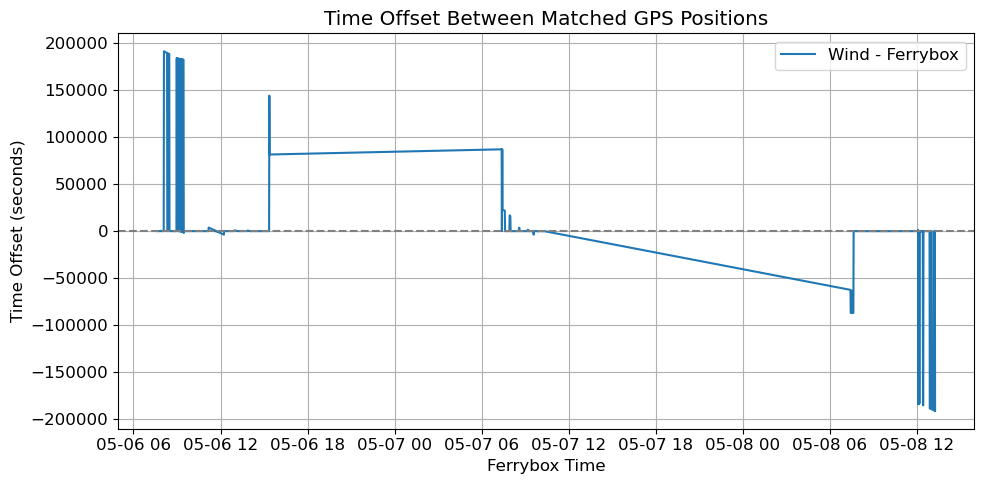

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_all_spatial['datetime'], df_all_spatial['time_offset_s'], label='Wind - Ferrybox')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Ferrybox Time')
plt.ylabel('Time Offset (seconds)')
plt.title('Time Offset Between Matched GPS Positions')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
df_time_filtered = df_all_spatial[np.abs(df_all_spatial['time_offset_s']) < 300]
print(df_time_filtered.shape)
print(df_time_filtered['gps_spatial_offset_m'].describe())


(794, 47)
count    794.000000
mean     183.103766
std       93.146065
min        1.697317
25%      150.058387
50%      207.569978
75%      249.230126
max      332.863828
Name: gps_spatial_offset_m, dtype: float64


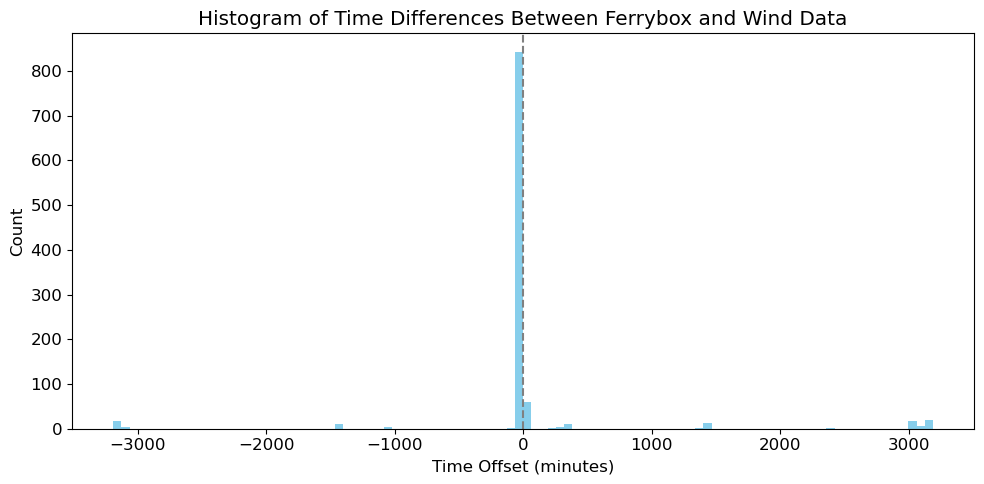

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df_all_spatial['time_offset_s'] / 60, bins=100, color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Time Offset (minutes)')
plt.ylabel('Count')
plt.title('Histogram of Time Differences Between Ferrybox and Wind Data')
plt.tight_layout()
plt.show()


In [116]:
# Constants
f = 2 * 7.2921e-5 * np.sin(np.deg2rad(df_time_filtered['Latitude'].mean()))  # Coriolis
Cp = 4000  # J/kg/K
alpha = 1e-4
g = 9.81
tau_const = 0.02  # Or use df_time_filtered['tau'] if available

# Calculate EBF if not already present
if 'Q_EBF' not in df_time_filtered.columns:
    df_time_filtered.loc[:, 'Q_EBF'] = -((df_time_filtered['buoy_grad'] * tau_const) / f) * (Cp / (alpha * g))



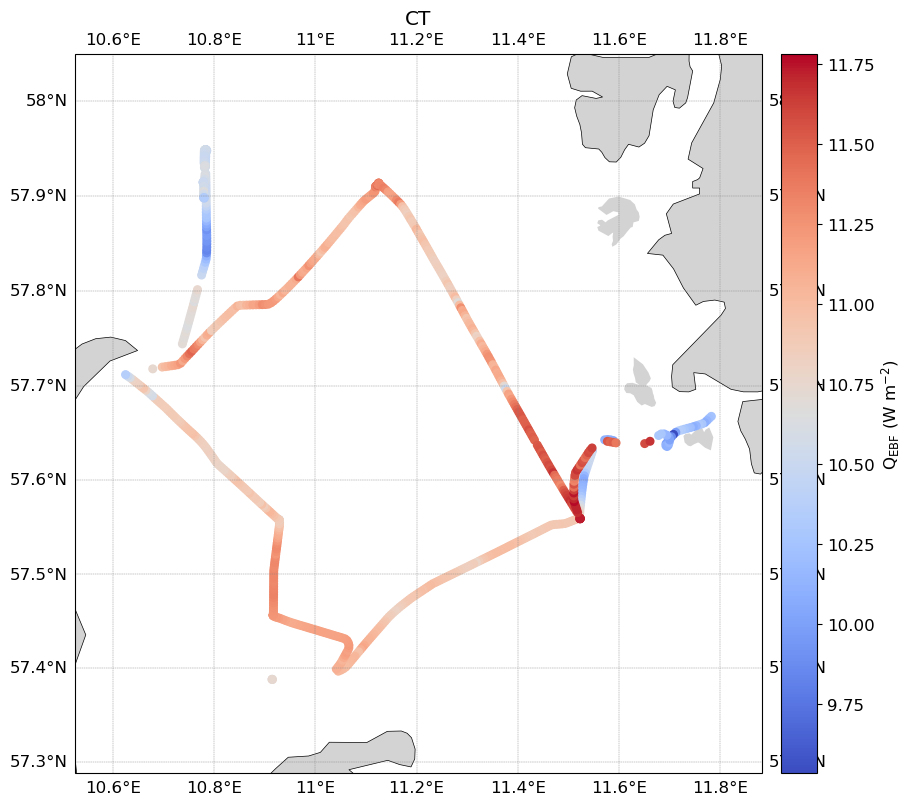

In [119]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent with buffer
lat_min, lat_max = df_time_filtered['Latitude'].min(), df_time_filtered['Latitude'].max()
lon_min, lon_max = df_time_filtered['Longitude'].min(), df_time_filtered['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', linestyle='--')

# Scatter plot of Q_EBF
sc = ax.scatter(df_time_filtered['Longitude'], df_time_filtered['Latitude'],
                c=df_time_filtered['CT'], cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('CT')
plt.tight_layout()
plt.show()


Compute corilois and then EBF

In [34]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [35]:
# prepare the two source tables
bx   = df_all[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      # 1 007 rows
tau  = df[['ts','tau']].rename(columns={'ts':'datetime'})  # 3 258 rows

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')


# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
alpha = 10**-4
g = 9.82
tau_const = 0.02

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * tau_const) / (f)) * ((Cp) / (alpha * g))

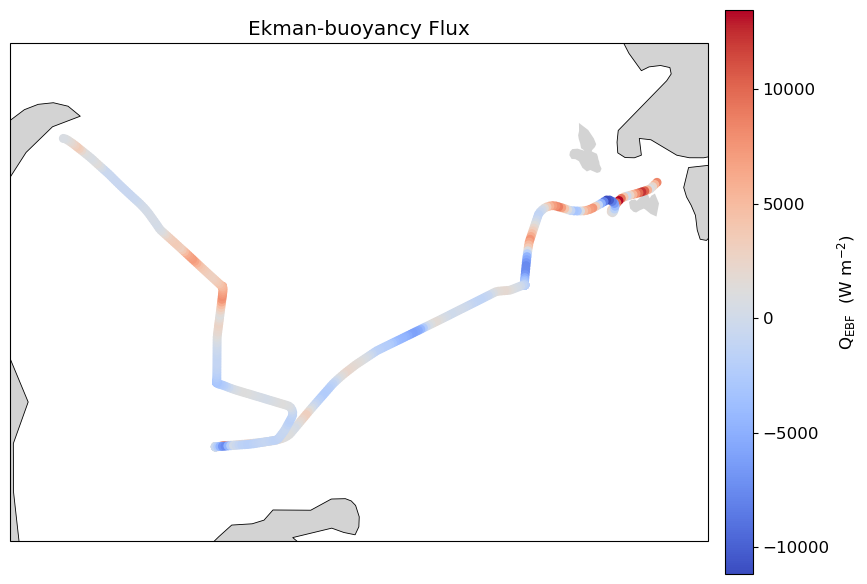

In [36]:
# 3.  scatter along the transect
fig = plt.figure(figsize=(9,6))
ax  = plt.axes(projection=ccrs.Mercator())
ax.set_extent([combo['Longitude'].min()-0.1, combo['Longitude'].max()+0.1, combo['Latitude' ].min()-0.1, 
               combo['Latitude' ].max()+0.1], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, lw=0.6)
ax.add_feature(cfeature.LAND,     facecolor='lightgrey')

sc = ax.scatter(combo['Longitude'], combo['Latitude'],
                c=combo['Q_EBF'],
                cmap='coolwarm',  s=30,
                transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$  (W m$^{-2}$)')   # units

ax.set_title('Ekman-buoyancy Flux')
plt.tight_layout()
plt.show()

In [23]:
print(df['tau'])

0       0.021691
1       0.020434
2       0.018033
3       0.011727
4       0.027085
          ...   
3253    0.024210
3254    0.000467
3255    0.001195
3256    0.005398
3257    0.031403
Name: tau, Length: 3258, dtype: float64


In [25]:
print(df['tau_y'])

0      -0.021217
1      -0.019910
2      -0.015922
3      -0.011640
4      -0.027019
          ...   
3253   -0.002110
3254    0.000460
3255   -0.000543
3256   -0.001030
3257   -0.005453
Name: tau_y, Length: 3258, dtype: float64


In [53]:
print("τ  (Pa)          :", combo['tau'].abs().describe())
print("∂b/∂x (s⁻2 m⁻1) :", combo['buoy_grad'].abs().describe())
print("f  (s⁻1)         :", f)


τ  (Pa)          : count    468.000000
mean       0.137279
std        0.096299
min        0.000000
25%        0.074487
50%        0.111344
75%        0.200124
max        0.467652
Name: tau, dtype: float64
∂b/∂x (s⁻2 m⁻1) : count    4.600000e+02
mean     1.732169e-06
std      1.534266e-06
min      1.767195e-08
25%      6.239993e-07
50%      1.309217e-06
75%      2.265712e-06
max      7.935522e-06
Name: buoy_grad, dtype: float64
f  (s⁻1)         : 0.00012231339297029653
